In [1]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
import os
import copy
import math
from gensim import corpora
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# FUNCTIONS AND GLOBALS

In [2]:
with open('input/languages.txt', 'r') as file:
    languages = [f.strip('\n') for f in file.readlines()]

In [3]:
def read_text(datatype, folder, filename):
    with open(os.path.join(datatype, folder, filename), 'r') as file:
        return file.read()
    
def get_wordcount_by_lang(text_dict, unique=False):
    if unique:
        dictionaries = {lan: corpora.Dictionary([text_dict[lan]]) for lan in text_dict.keys()}
        return {k: len(v) for k, v in dictionaries.items()}
    else:
        return {k: len(v) for k, v in text_dict.items()}

# READ CORPUS

In [4]:
files = {lan: os.listdir(os.path.join('page_text', lan)) for lan in languages}

In [5]:
# plain texts
texts = {lan: {f[:-4]: read_text('page_text', lan, f).lower() 
               for f in files[lan]} 
         for lan in languages}

# CREATE TOKENIZED TEXT

In [6]:
# tokenized text - remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
texts_split = {lan: {key: tokenizer.tokenize(text) for key, text in texts[lan].items()} for lan in languages}

# JOIN TEXT BY LANGUAGE

In [7]:
text_bylang = {lan: sum([val for key, val in texts_split[lan].items()], []) for lan in languages}

# WORDCOUNTS FOR RAW TEXT

In [8]:
df_wordcounts_raw = pd.DataFrame(index = languages)
df_wordcounts_raw['countRaw'] = df_wordcounts_raw.index.map(get_wordcount_by_lang(text_bylang))
df_wordcounts_raw['countUnique'] = df_wordcounts_raw.index.map(get_wordcount_by_lang(text_bylang, True))
df_wordcounts_raw

,countRaw,countUnique
en,3191139,91738
de,1673767,134302
hu,818669,111097
ro,547997,56173


# BARPLOT FOR RAW TEXT

Text(0.5, 0.98, 'Word counts and unique word counts by languages in raw text')

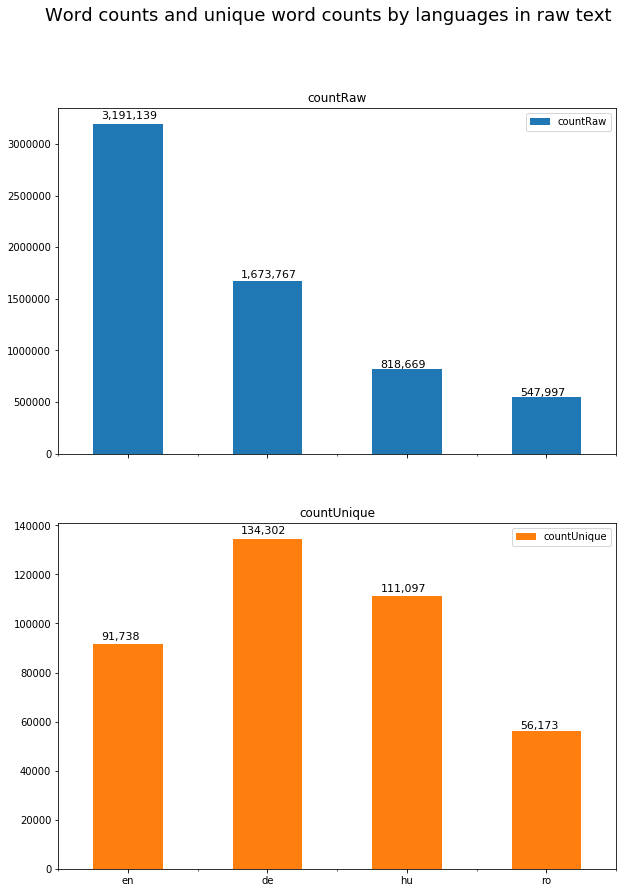

In [142]:
ax = df_wordcounts_raw.plot.bar(rot=0, subplots=True, figsize=(10,14))
for axis in ax:
    for p in axis.patches:
        axis.annotate(f'{p.get_height():,}', (p.get_x() + 0.06, p.get_height() * 1.018), fontsize=11)
fig = plt.gcf()
fig.suptitle('Word counts and unique word counts by languages in raw text', fontsize=18)

In [144]:
fig.savefig('outputs/rawText_barplot.png')

# STOPWORD REMOVAL

In [11]:
# long format of languages for stopword identification
languages_long = {'en': 'english', 'de': 'german', 'hu': 'hungarian', 'ro': 'romanian'}

# create dict of stopwords by language
stopwords_bylang = {lan: set(stopwords.words(languages_long[lan])) for lan in languages}

# filter stopwords from text
text_bylang_stop = {lan: [f for f in text_bylang[lan] if not f in stopwords_bylang[lan]] for lan in languages}

# WORDCOUNTS FOR STOPWORD REMOVED TEXT

In [12]:
df_wordcounts_nostop = pd.DataFrame(index = languages)
df_wordcounts_nostop['countRaw'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stop))
df_wordcounts_nostop['countUnique'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stop, True))
df_wordcounts_nostop

,countRaw,countUnique
en,1955467,91586
de,1088246,134076
hu,609245,110909
ro,365645,55894


# BARPLOT FOR STOPWORD REMOVED  TEXT

Text(0.5, 0.98, 'Word counts and unique word counts by languages after stopword removal')

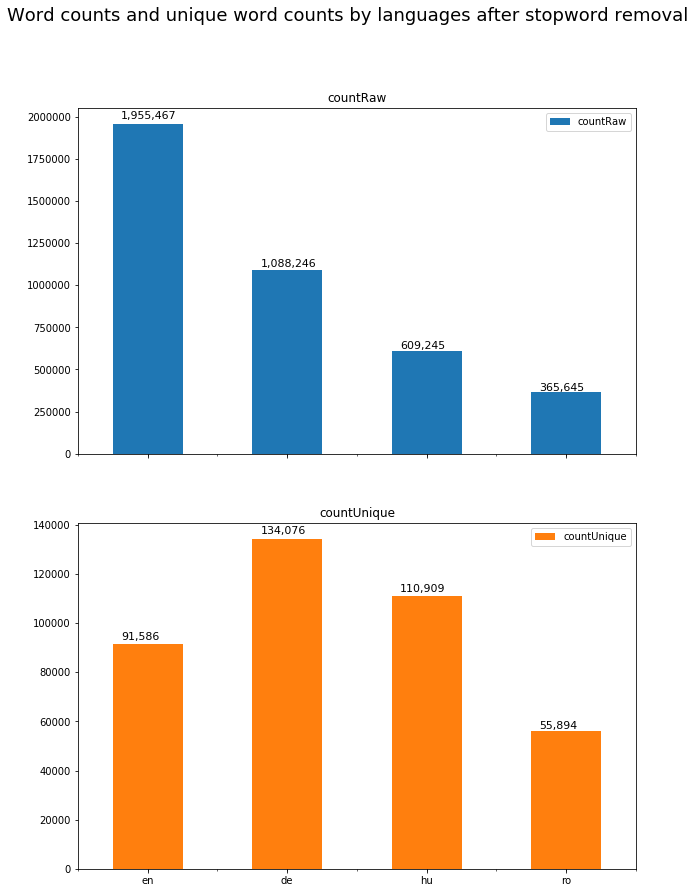

In [49]:
ax = df_wordcounts_nostop.plot.bar(rot=0, subplots=True, figsize=(10,14))
for axis in ax:
    for p in axis.patches:
        axis.annotate(f'{p.get_height():,}', (p.get_x() + 0.06, p.get_height() * 1.018), fontsize=11)
fig = plt.gcf()
fig.suptitle('Word counts and unique word counts by languages after stopword removal', fontsize=18)

In [151]:
df_nostop_comp = df_wordcounts_nostop[['countRaw']].rename(columns={'countRaw': 'countNoStop'}).join(df_wordcounts_raw['countRaw'])
df_nostop_comp['Nostop/Raw'] = df_nostop_comp['countNoStop'] / df_nostop_comp['countRaw']

Text(0.5, 0.98, 'Ratio of non-stopword words in different languages')

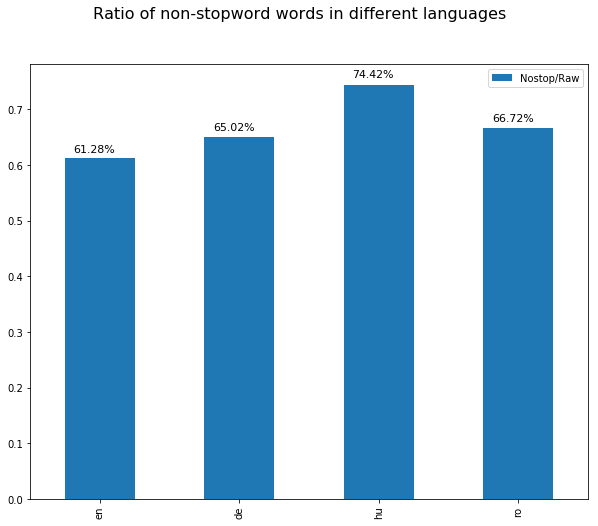

In [162]:
axis=df_nostop_comp[['Nostop/Raw']].plot.bar(figsize=(10,8))
for p in axis.patches:
        axis.annotate(f'{round(p.get_height(),4)*100}%', (p.get_x() + 0.06, p.get_height() * 1.018), fontsize=11)
fig = plt.gcf()
fig.suptitle('Ratio of non-stopword words in different languages', fontsize=16)

In [163]:
fig.savefig('outputs/stopwVSraw.png')

# STEMMING TEXT

In [14]:
# define stemmer objects by language
stemmers = {lan: SnowballStemmer(languages_long[lan]) for lan in languages}

# stem text
text_bylang_stemmed = {lan: [stemmers[lan].stem(word) for word in text_bylang[lan]] for lan in languages}

# stem and remove stopwords
text_bylang_stop_stemmed = {lan: [stemmers[lan].stem(word) for word in text_bylang_stop[lan]] for lan in languages}

# WORDCOUNTS FOR STOPWORD REMOVED TEXT

* now only unique counts make sense

In [15]:
df_wordcounts_stem_stop = pd.DataFrame(index = languages)
df_wordcounts_stem_stop['stemOnly'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stemmed, True))
df_wordcounts_stem_stop['stemStop'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stop_stemmed, True))
df_wordcounts_stem_stop

,stemOnly,stemStop
en,70851,70750
de,101670,101604
hu,67584,67549
ro,36962,36798


# BARPLOT FOR STEMMED AND STOPWORD REMOVED  TEXT

Text(0.5, 0.98, 'Word counts and unique word counts by languages after stopword removal')

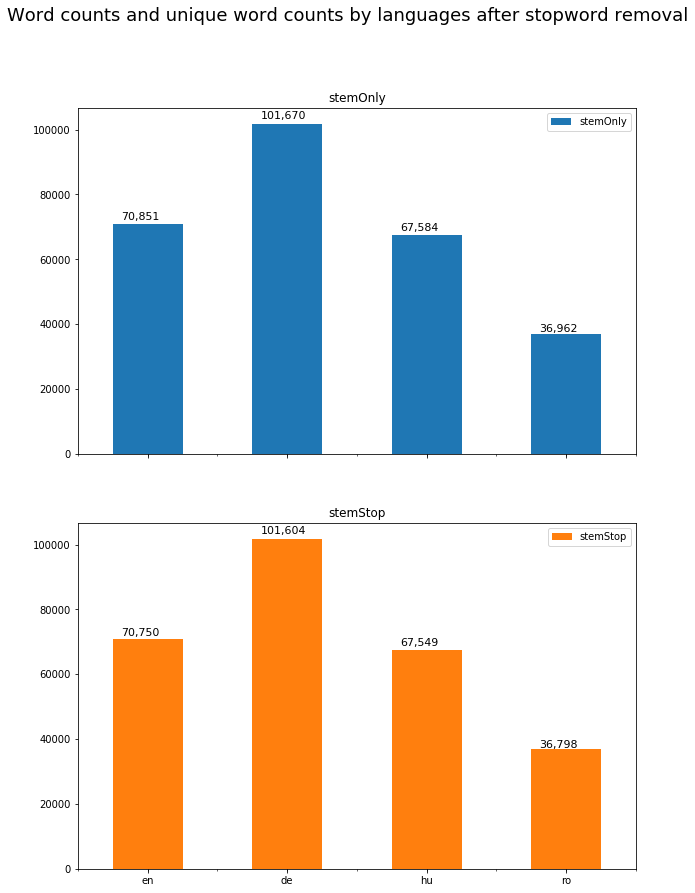

In [52]:
ax = df_wordcounts_stem_stop.plot.bar(rot=0, subplots=True, figsize=(10,14))
for axis in ax:
    for p in axis.patches:
        axis.annotate(f'{p.get_height():,}', (p.get_x() + 0.06, p.get_height() * 1.018), fontsize=11)
fig = plt.gcf()
fig.suptitle('Word counts and unique word counts by languages after stopword removal', fontsize=18)

# COMPARE TO RAW COUNTS

In [53]:
# get divisor -> raw unique counts
df_wordcounts_stem_stop['rawUnique'] = df_wordcounts_raw['countUnique']

In [54]:
# divide to get ratios to raw unique counts
for col in ['stemOnly', 'stemStop']:
    df_wordcounts_stem_stop[f'{col}_ratio'] = df_wordcounts_stem_stop[col] / df_wordcounts_stem_stop['rawUnique']

# BARPLOT OF RATIOS TO RAW TEXT

Text(0.5, 0.98, 'Ratio of unique words kept by languages after stemming only, and after stemming+stopword removal')

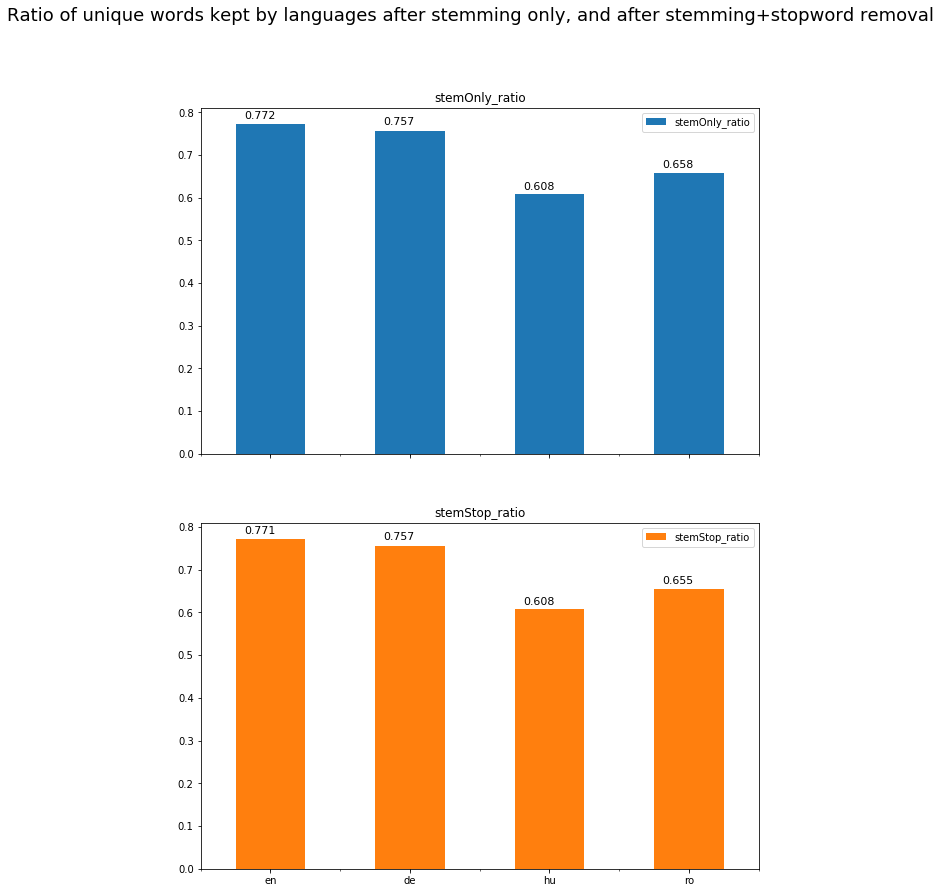

In [59]:
ax = df_wordcounts_stem_stop[[f for f in df_wordcounts_stem_stop.columns if 'ratio' in f]].plot.bar(rot=0, subplots=True, figsize=(10,14))
for axis in ax:
    for p in axis.patches:
        axis.annotate(f'{round(p.get_height(),3)}', (p.get_x() + 0.06, p.get_height() * 1.018), fontsize=11)
fig = plt.gcf()
fig.suptitle('Ratio of unique words kept by languages after stemming only, and after stemming+stopword removal', fontsize=18)

# AGGREGATED INFORMATION FROM THIS PART

## RAW COUNTS

In [60]:
counts_sum_df = pd.DataFrame(index=languages)
counts_sum_df['Raw'] = df_wordcounts_raw[['countRaw']]
counts_sum_df['NoStop'] = df_wordcounts_nostop['countRaw']
counts_sum_df['Stemmed'] = counts_sum_df['NoStop']
counts_sum_df['NoStopStemmed'] = counts_sum_df['Stemmed']

In [61]:
counts_sum_df

,Raw,NoStop,Stemmed,NoStopStemmed
en,3191139,1955467,1955467,1955467
de,1673767,1088246,1088246,1088246
hu,818669,609245,609245,609245
ro,547997,365645,365645,365645


## UNIQUE COUNTS

In [62]:
uniques_sum_df = pd.DataFrame(index=languages)
uniques_sum_df['Raw'] = df_wordcounts_raw['countUnique']
uniques_sum_df['NoStop'] = df_wordcounts_nostop['countUnique']
uniques_sum_df['Stemmed'] = df_wordcounts_stem_stop['stemOnly']
uniques_sum_df['NoStopStemmed'] = df_wordcounts_stem_stop['stemStop']

In [63]:
uniques_sum_df

,Raw,NoStop,Stemmed,NoStopStemmed
en,91738,91586,70851,70750
de,134302,134076,101670,101604
hu,111097,110909,67584,67549
ro,56173,55894,36962,36798


## BAR CHART

In [64]:
uniques_sum_df_perc = uniques_sum_df.copy()
for col in ['NoStop', 'Stemmed', 'NoStopStemmed']:
    uniques_sum_df_perc[col] /= uniques_sum_df_perc['Raw']

Text(0.5, 0.98, 'Unique word count ratios to raw text by method')

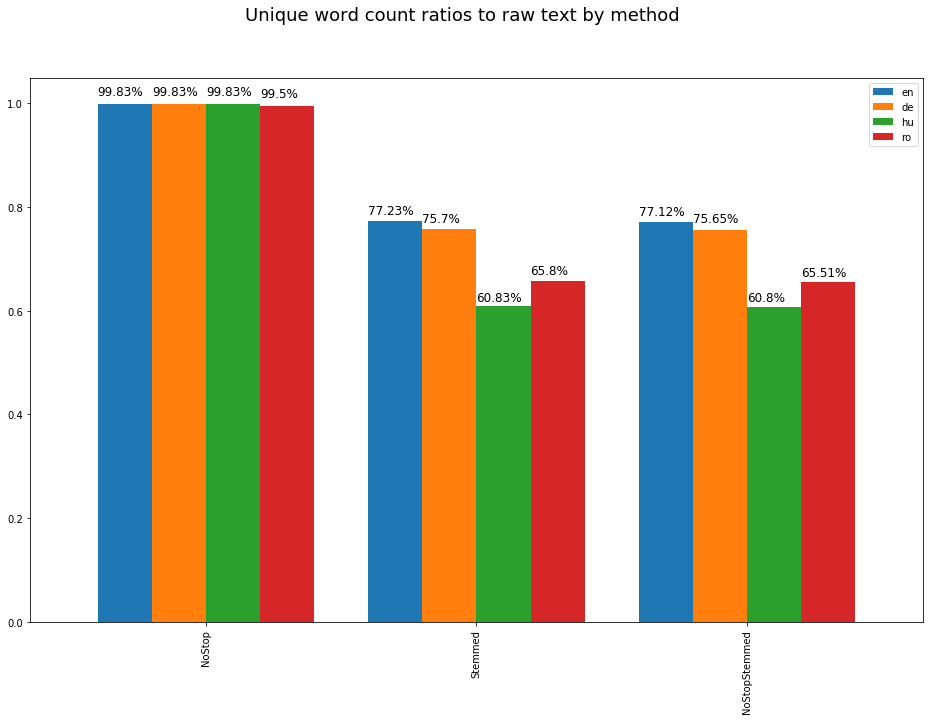

In [254]:
ax = uniques_sum_df_perc.drop('Raw', axis=1).T.plot.bar(figsize=(16,10), width=0.8)
for p in ax.patches:
        ax.annotate(f'{round(p.get_height()*100,2)}%', (p.get_x(), p.get_height() * 1.018), fontsize=12)
fig = plt.gcf()
fig.suptitle('Unique word count ratios to raw text by method', fontsize=18)

In [255]:
fig.savefig('outputs/stopStemComp.png')

Text(0.5, 0.98, 'Unique word count ratios to raw text by language')

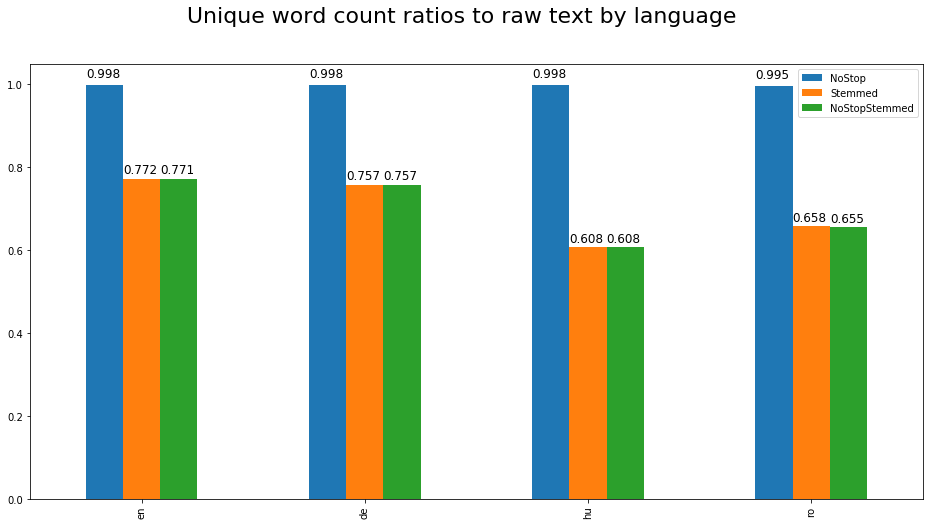

In [77]:
ax = uniques_sum_df_perc.drop('Raw', axis=1).plot.bar(figsize=(16,8))
for p in ax.patches:
        ax.annotate(f'{round(p.get_height(),3)}', (p.get_x(), p.get_height() * 1.018), fontsize=12)
fig = plt.gcf()
fig.suptitle('Unique word count ratios to raw text by language', fontsize=22)

# CREATE STEMMED, STOPWORD REMOVED CORPUS BY DOC

In [78]:
texts_bylang_byhuman = {lan:
                        {key:
                         [stemmers[lan].stem(word) 
                          for word in val if not word in stopwords_bylang[lan]] 
                         for key, val in texts_split[lan].items()} 
                        for lan in languages}

In [79]:
dictionary_bylang_byhuman = {lan: corpora.Dictionary(texts_bylang_byhuman[lan].values()) for lan in languages}

## PLOT DOCUMENT FREQUENCY HISTOGRAM

Text(0.5, 0.98, 'Document frequency has a long, thin tail')

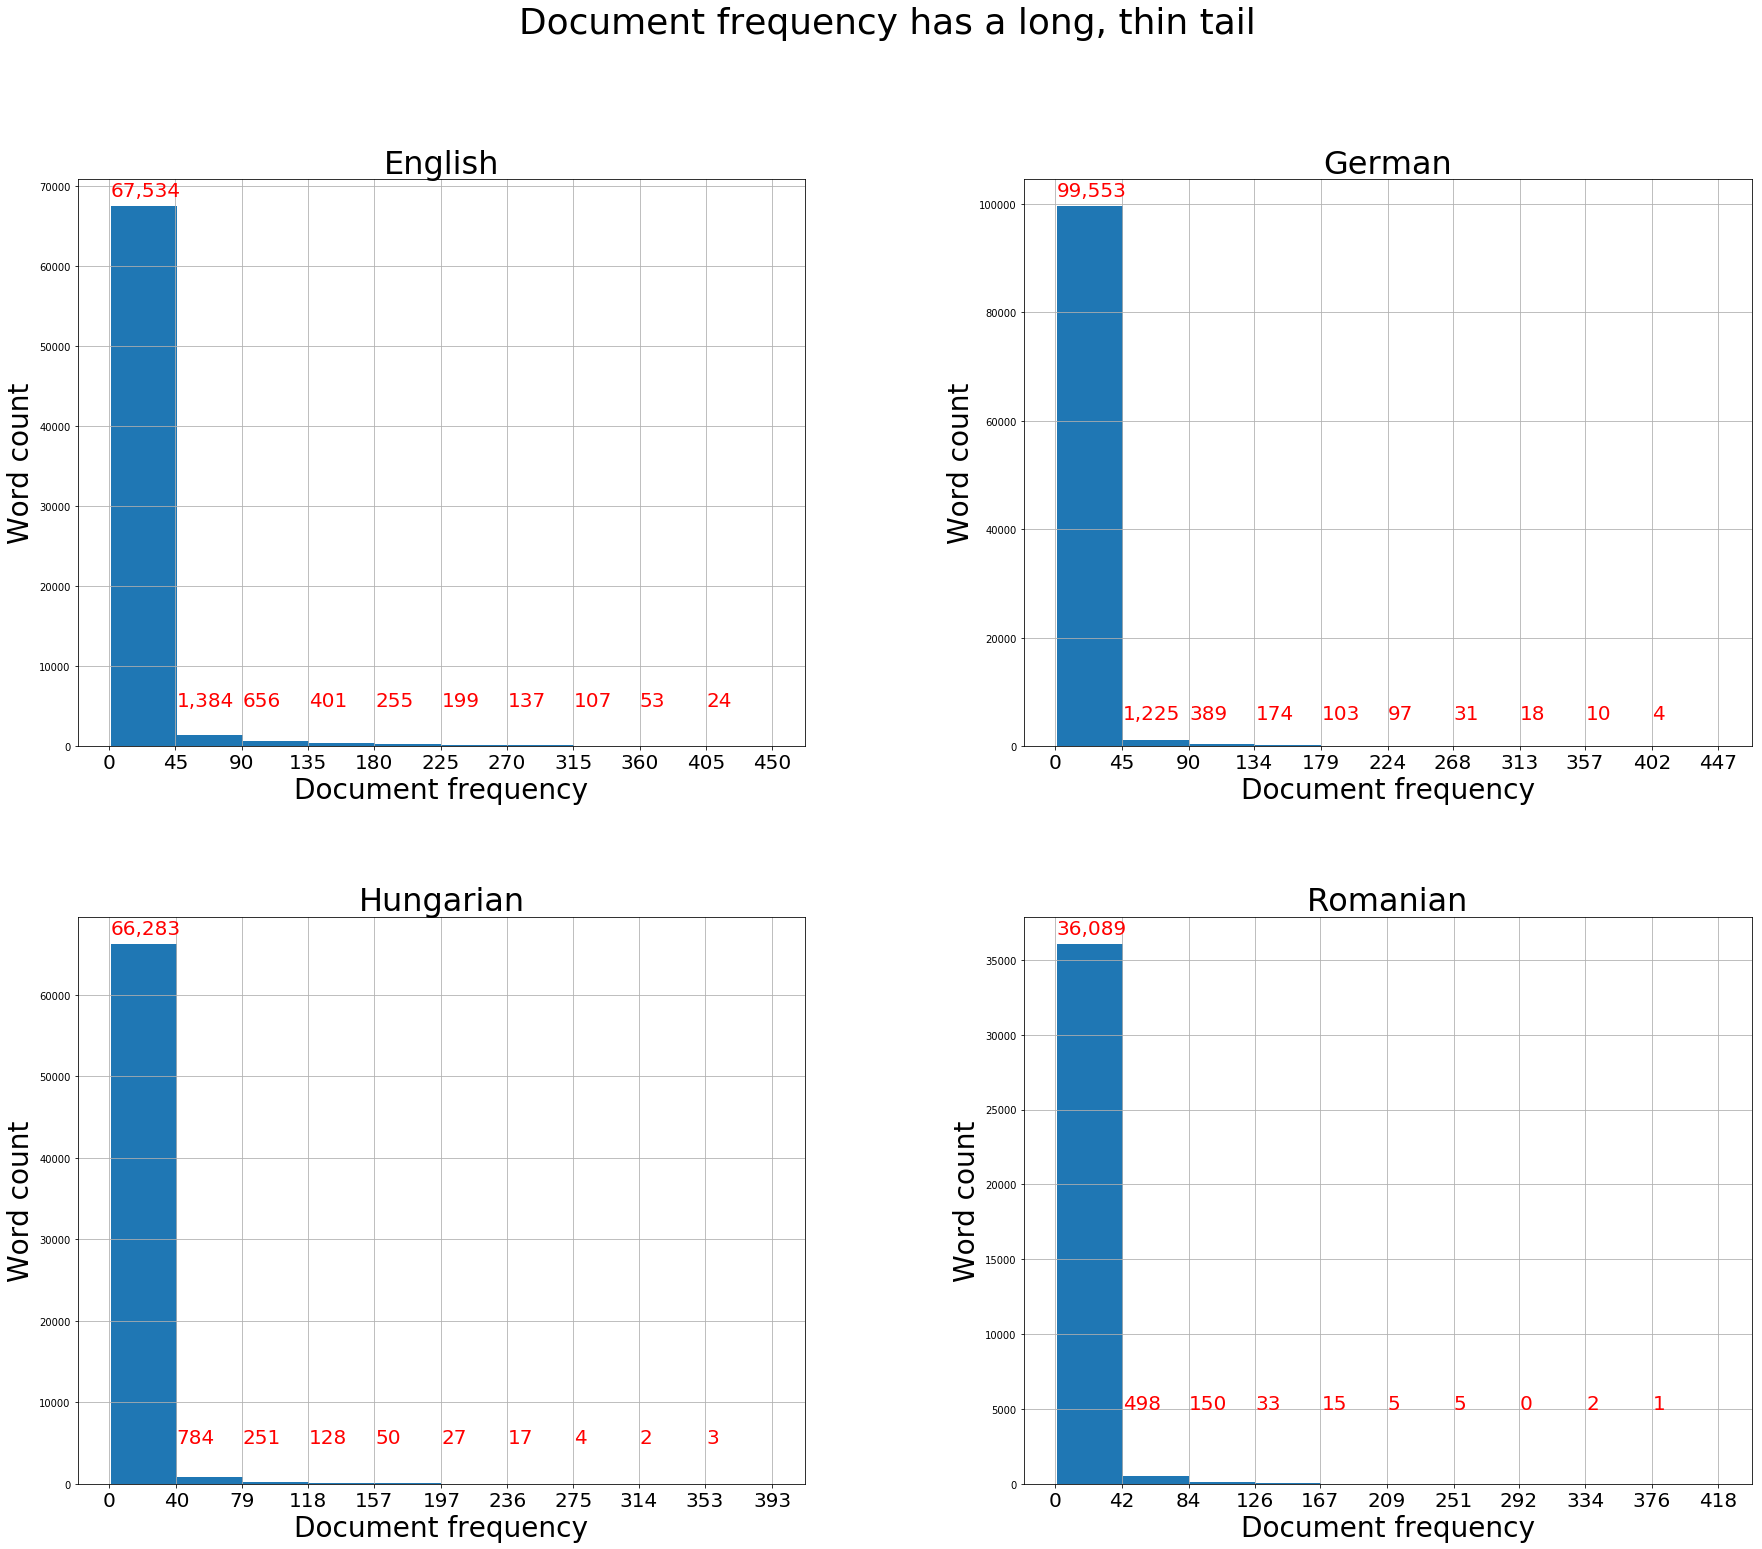

In [313]:
fig, ax = plt.subplots(2,2, figsize=(30,24))
ax_flat = [item for sublist in ax for item in sublist]
for lan, axis in zip(languages, ax_flat):
    docfreq = pd.DataFrame.from_dict(dictionary_bylang_byhuman[lan].dfs, orient='index').rename(
        columns={0: f'{languages_long[lan].capitalize()}'})
    docfreq.hist(figsize=(8,6), ax=axis, bins=10)
    axis.set_title(f'{languages_long[lan].capitalize()}', fontsize=32)
    x_ticks = pd.cut(docfreq[f'{languages_long[lan].capitalize()}'], 10, retbins=True)[1]
    axis.set_ylabel('Word count', fontsize=28)
    axis.set_xlabel('Document frequency', fontsize=28)
    axis.set_xticks([int(tick) for tick in x_ticks])
    for p in axis.patches:
        axis.annotate(f'{int(p.get_height()):,}', (p.get_x(), max(p.get_height() * 1.018, 5000)), fontsize=20, color='red')
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
fig.suptitle('Document frequency has a long, thin tail', fontsize=36)

In [314]:
fig.savefig('outputs/docfreq.png')

# FREQUENT TERM REMOVAL

* a way to remove domain specific stopwords

In [80]:
# create frequency thresholds for percentages
freq_perc = {i: i/100 for i in [95, 90, 80, 50]}

In [81]:
freq_perc

{95: 0.95, 90: 0.9, 80: 0.8, 50: 0.5}

In [82]:
# remove sparse tokens
filtered_dicts_freq = {}
for lan in languages:
    filtered_dicts_freq[lan] = {}
    for k, v in freq_perc.items():
        filtered_dicts_freq[lan][k] = copy.copy(dictionary_bylang_byhuman[lan])
        filtered_dicts_freq[lan][k].filter_extremes(no_above=v, no_below=1, keep_n = len(dictionary_bylang_byhuman[lan]))

In [83]:
# create word counts for filtered dictionaries
word_counts_filtered_freq = {lan: {k: len(v) for k,v in filtered_dicts_freq[lan].items()} for lan in languages}

In [84]:
word_counts_filtered_freq

{'en': {95: 70736, 90: 70727, 80: 70675, 50: 70237},
 'de': {95: 101601, 90: 101600, 80: 101591, 50: 101448},
 'hu': {95: 67549, 90: 67549, 80: 67547, 50: 67521},
 'ro': {95: 36798, 90: 36797, 80: 36796, 50: 36788}}

## ABSOLUTE WORD COUNTS

In [85]:
freq_df = pd.DataFrame.from_dict(get_wordcount_by_lang(text_bylang_stop_stemmed, True), orient='index')
freq_df.columns = ['no removal']
freq_df_ = pd.DataFrame.from_dict(word_counts_filtered_freq).T
freq_df = freq_df.join(freq_df_)
freq_df

,no removal,50,80,90,95
en,70750,70237,70675,70727,70736
de,101604,101448,101591,101600,101601
hu,67549,67521,67547,67549,67549
ro,36798,36788,36796,36797,36798


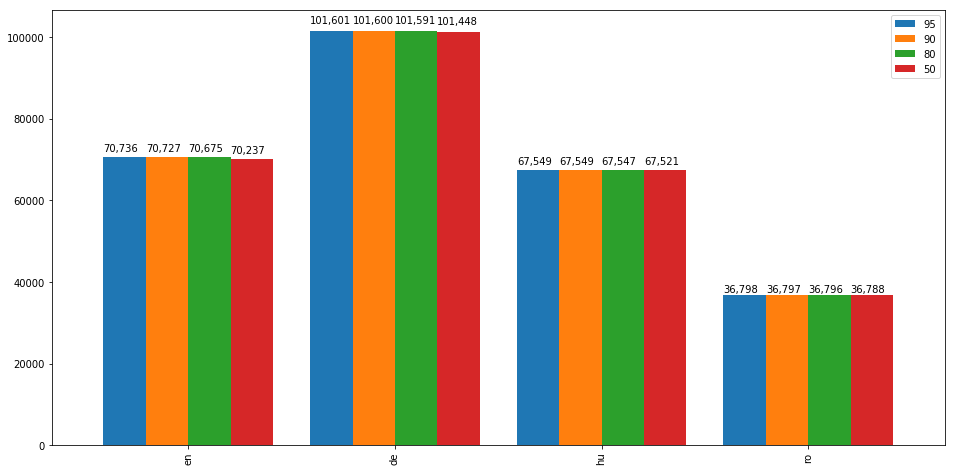

In [104]:
# plot absolute counts in a grouped barchart by language
ax = freq_df.drop('no removal', axis=1)[[95,90,80,50]].plot.bar(figsize=(16,8),  width=0.82)
for p in ax.patches:
        ax.annotate(f'{p.get_height():,}', (p.get_x(), p.get_height() * 1.018), fontsize=10)

## RELATIVE WORD COUNTS

In [102]:
freq_df_perc = freq_df.copy()
for i in [95,90,80,50]:
    freq_df_perc[i] /= freq_df_perc['no removal']
freq_df_perc['no removal'] = 1

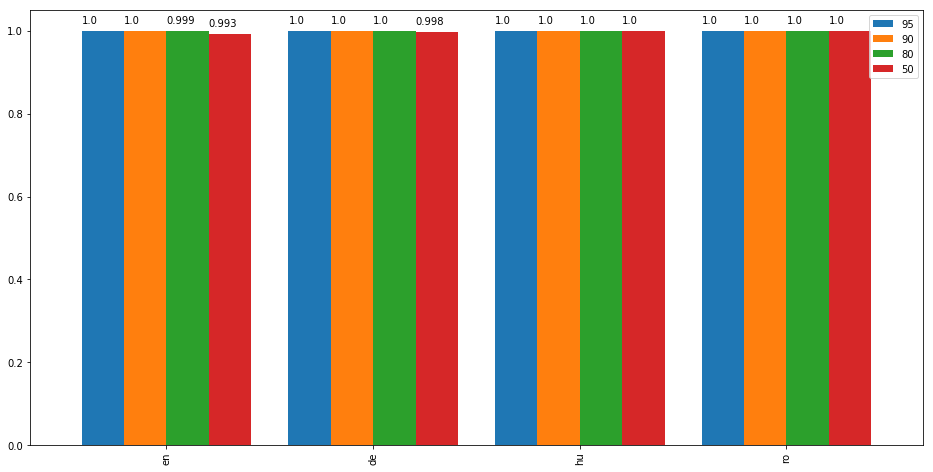

In [114]:
# plot relative counts in a grouped barchart by language
ax = freq_df_perc.drop('no removal', axis=1)[[95,90,80,50]].plot.bar(figsize=(16,8),  width=0.82)
for p in ax.patches:
        ax.annotate(f'{round(p.get_height(),3)}', (p.get_x(), p.get_height() * 1.018), fontsize=10)

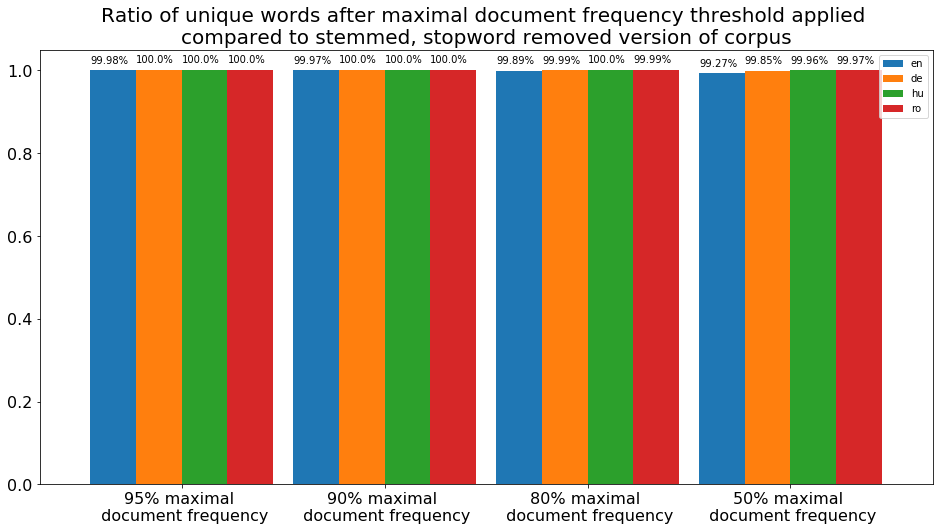

In [353]:
# plot relative counts in a grouped barchart by frequency criteria of removal
fig, ax = plt.subplots()
freq_df_perc.drop('no removal', axis=1)[[95,90,80,50]].T.plot.bar(figsize=(16,8),  width=0.9, ax=ax)
ax.set_title('Ratio of unique words after maximal document frequency threshold applied \ncompared to stemmed, stopword removed version of corpus', fontsize=20)
ax.tick_params(axis='x', labelrotation=0, labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels([f'{rat} maximal \n document frequency' for rat in ['95%', '90%', '80%', '50%']])
for p in ax.patches:
        ax.annotate(f'{(round(p.get_height() * 100,2))}%', (p.get_x(), p.get_height() * 1.018), fontsize=10)

In [354]:
fig.savefig('outputs/freqRem.png')

# SPARSE TERM REMOVAL

In [238]:
# create sparsity thresholds for percentages
SPARSE_TRESH = [0.5, 1, 5, 10]
sparse_perc = {k: math.ceil(k * len(texts['en'].keys()) / 100) for k in SPARSE_TRESH}

In [239]:
sparse_perc

{0.5: 3, 1: 5, 5: 23, 10: 46}

In [240]:
# remove sparse tokens
filtered_dicts_sparse = {}
for lan in languages:
    filtered_dicts_sparse[lan] = {}
    for k, v in sparse_perc.items():
        filtered_dicts_sparse[lan][k] = copy.deepcopy(dictionary_bylang_byhuman[lan])
        filtered_dicts_sparse[lan][k].filter_extremes(no_below=v, no_above=1, keep_n=len(dictionary_bylang_byhuman[lan]))

In [241]:
# create word counts for filtered dictionaries
word_counts_filtered_sparse = {lan: {k: len(v) for k,v in filtered_dicts_sparse[lan].items()} for lan in languages}

In [242]:
word_counts_filtered_sparse

{'en': {0.5: 20627, 1: 14472, 5: 5217, 10: 3216},
 'de': {0.5: 24476, 1: 15502, 5: 4141, 10: 2051},
 'hu': {0.5: 17559, 1: 10828, 5: 2518, 10: 1091},
 'ro': {0.5: 10657, 1: 6793, 5: 1603, 10: 656}}

## ABSOLUTE WORD COUNTS

In [243]:
sparse_df = pd.DataFrame.from_dict(get_wordcount_by_lang(text_bylang_stop_stemmed, True), orient='index')
sparse_df.columns = ['no removal']
sparse_df_ = pd.DataFrame.from_dict(word_counts_filtered_sparse).T
sparse_df = sparse_df.join(sparse_df_)
sparse_df

,no removal,0.5,1.0,5.0,10.0
en,70750,20627,14472,5217,3216
de,101604,24476,15502,4141,2051
hu,67549,17559,10828,2518,1091
ro,36798,10657,6793,1603,656


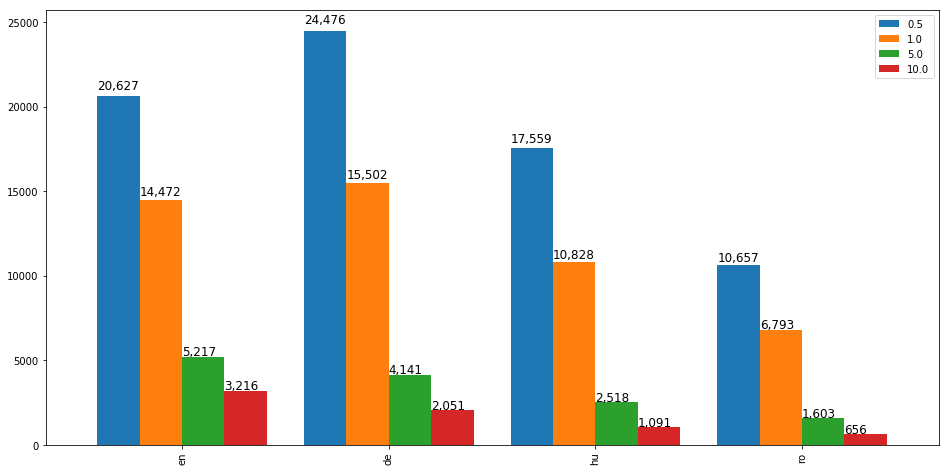

In [244]:
# plot absolute counts in a grouped barchart by language
ax=sparse_df.drop('no removal', axis=1).plot.bar(figsize=(16,8),  width=0.82)
for p in ax.patches:
        ax.annotate(f'{p.get_height():,}', (p.get_x(), p.get_height() * 1.018), fontsize=12)

## RELATIVE WORD COUNTS

In [245]:
sparse_df_perc = sparse_df.copy()
for i in SPARSE_TRESH:
    sparse_df_perc[i] /= sparse_df_perc['no removal']
sparse_df_perc['no removal'] = 1

In [246]:
sparse_df_perc

,no removal,0.5,1.0,5.0,10.0
en,1,0.291548,0.204551,0.073739,0.045456
de,1,0.240896,0.152573,0.040756,0.020186
hu,1,0.259945,0.160298,0.037277,0.016151
ro,1,0.289608,0.184602,0.043562,0.017827


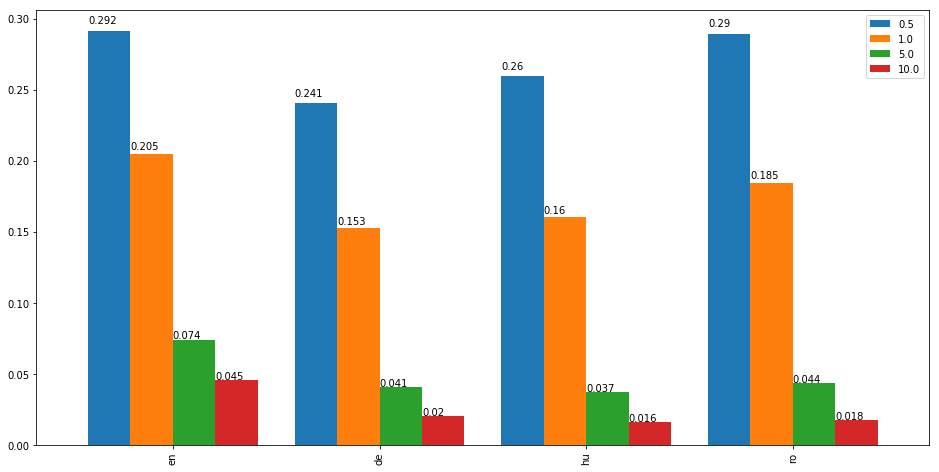

In [247]:
# plot relative counts in a grouped barchart by language
ax=sparse_df_perc.drop('no removal', axis=1).plot.bar(figsize=(16,8),  width=0.82)
for p in ax.patches:
        ax.annotate(f'{round(p.get_height(),3)}', (p.get_x(), p.get_height() * 1.018), fontsize=10)

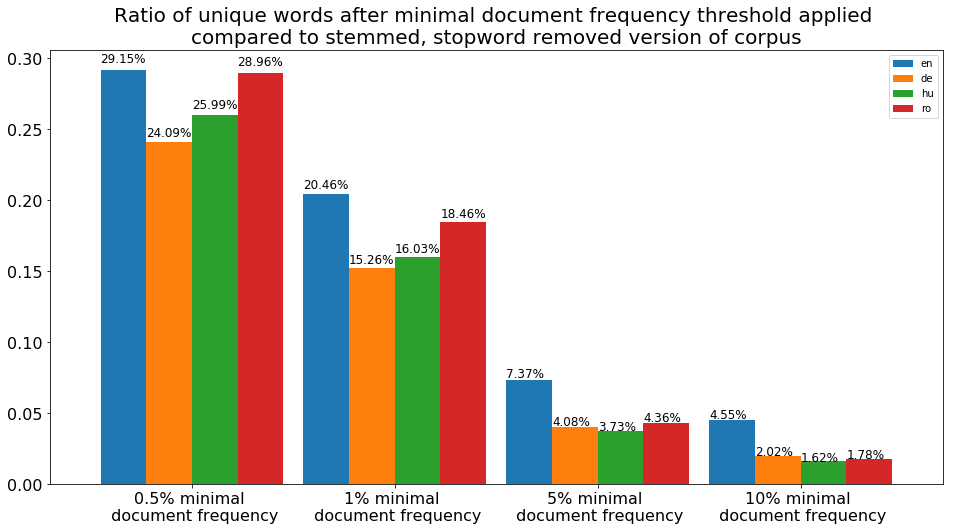

In [341]:
# plot relative counts in a grouped barchart by sparsity criteria of removal
fig, ax = plt.subplots()
sparse_df_perc.drop('no removal', axis=1).T.plot.bar(figsize=(16,8),  width=0.9, ax=ax)
ax.set_title('Ratio of unique words after minimal document frequency threshold applied \ncompared to stemmed, stopword removed version of corpus', fontsize=20)
ax.tick_params(axis='x', labelrotation=0, labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels([f'{rat} minimal \n document frequency' for rat in ['0.5%', '1%', '5%', '10%']])
for p in ax.patches:
        ax.annotate(f'{round(p.get_height()*100,2)}%', (p.get_x(), p.get_height() * 1.018), fontsize=12)

In [343]:
fig.savefig('outputs/sparseRem.png')